# Lab 12: Actor-Critic for Aiyagari Model

**Following the lecture:**
1. **Critic**: Q(s,a;φ) trained via Bellman equation
2. **Actor**: σ(s;θ) trained to maximize Q(s, σ(s))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import importlib

import model, algos
importlib.reload(model)
importlib.reload(algos)

from model import SimpleParams, tauchen
from algos import VFISolver, ActorCriticSolver

np.random.seed(42)
torch.manual_seed(42)
print('Ready!')

Ready!


## 1. Model Setup

In [2]:
params = SimpleParams()
z_grid, P_z = tauchen(params.rho, params.sigma, params.n_z)

print(f'Model: beta={params.beta}, gamma={params.gamma}, r={params.r}')
print(f'Assets: [{params.a_min}, {params.a_max}]')
print(f'Productivity: {z_grid}')

Model: beta=0.95, gamma=1.0, r=0.04
Assets: [0.0, 10.0]
Productivity: [0.74081822 1.34985881]


## 2. VFI Benchmark

In [3]:
vfi = VFISolver(params, z_grid, P_z, n_a=50)
a_grid, V_vfi, policy_vfi = vfi.solve()

Running VFI...
  Iter 50: diff = 3.08e-03
  Iter 100: diff = 2.17e-04
  Iter 150: diff = 1.67e-05
  Iter 200: diff = 1.28e-06
  Converged in 205 iterations


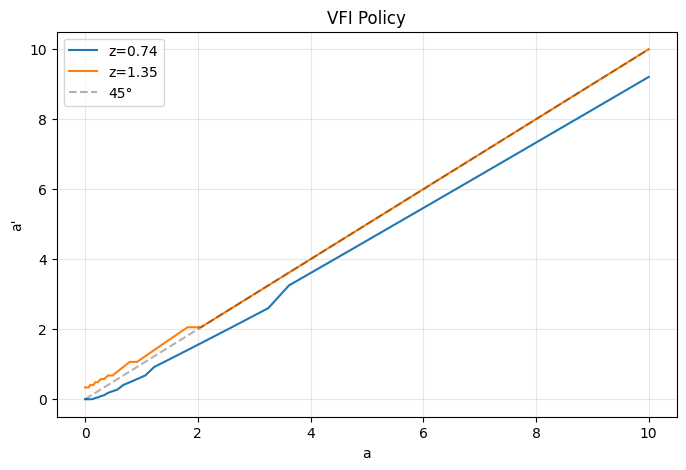

In [4]:
plt.figure(figsize=(8, 5))
for i_z in range(len(z_grid)):
    plt.plot(a_grid, policy_vfi[:, i_z], label=f'z={z_grid[i_z]:.2f}')
plt.plot(a_grid, a_grid, 'k--', alpha=0.3, label='45°')
plt.xlabel('a'); plt.ylabel("a'")
plt.title('VFI Policy')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

## 3. Actor-Critic Training

In [5]:
ac = ActorCriticSolver(params, z_grid, P_z, n_a=50, hidden_dim=64, lr=1e-3)

In [6]:
# Train (run multiple times to continue)
# stochastic=False (default): grid-based critic training (deterministic DP-style)
# stochastic=True: noisy action training (DDPG-style)
critic_losses, actor_losses = ac.solve(
    n_iterations=500,
    critic_updates=5,
    actor_updates=1,
    tau=0.005,
    stochastic=False,  # grid-based (default)
    verbose=True
)

Training Actor-Critic...
  Iter 50: Critic Loss=0.1932, Actor Loss=-0.8003
  Iter 100: Critic Loss=0.0227, Actor Loss=-0.7855
  Iter 150: Critic Loss=0.0063, Actor Loss=-0.8763
  Iter 200: Critic Loss=0.0044, Actor Loss=-0.9621
  Iter 250: Critic Loss=0.0034, Actor Loss=-1.0246
  Iter 300: Critic Loss=0.0027, Actor Loss=-1.0683
  Iter 350: Critic Loss=0.0017, Actor Loss=-1.1390
  Iter 400: Critic Loss=0.0014, Actor Loss=-1.1998
  Iter 450: Critic Loss=0.0012, Actor Loss=-1.2384
  Iter 500: Critic Loss=0.0010, Actor Loss=-1.2699
  Iter 550: Critic Loss=0.0009, Actor Loss=-1.2956
  Iter 600: Critic Loss=0.0007, Actor Loss=-1.3266
  Iter 650: Critic Loss=0.0006, Actor Loss=-1.3525
  Iter 700: Critic Loss=0.0005, Actor Loss=-1.3815
  Iter 750: Critic Loss=0.0005, Actor Loss=-1.4123
  Iter 800: Critic Loss=0.0004, Actor Loss=-1.4242
  Iter 850: Critic Loss=0.0004, Actor Loss=-1.4520
  Iter 900: Critic Loss=0.0003, Actor Loss=-1.4759
  Iter 950: Critic Loss=0.0003, Actor Loss=-1.4921
  Iter 

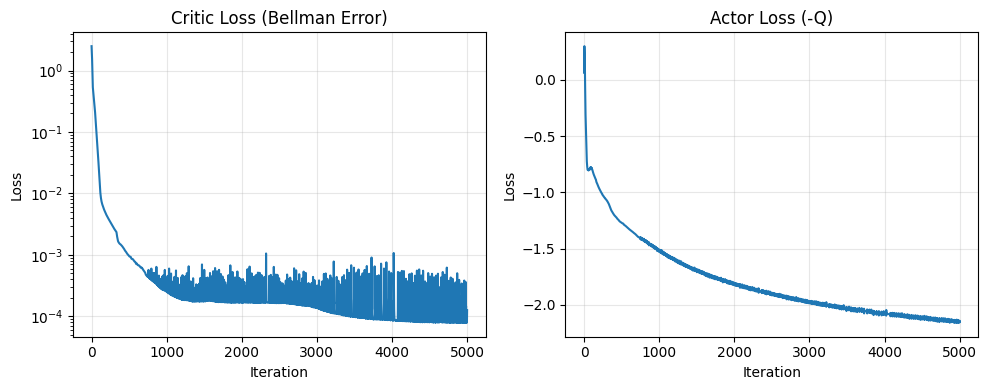

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(critic_losses)
axes[0].set_xlabel('Iteration'); axes[0].set_ylabel('Loss')
axes[0].set_title('Critic Loss (Bellman Error)')
axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

axes[1].plot(actor_losses)
axes[1].set_xlabel('Iteration'); axes[1].set_ylabel('Loss')
axes[1].set_title('Actor Loss (-Q)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## 4. Compare with VFI

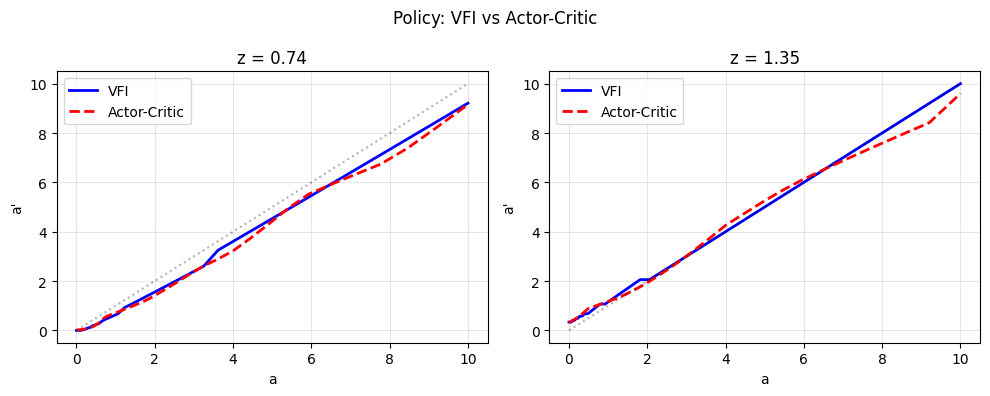

In [8]:
n_z = len(z_grid)
fig, axes = plt.subplots(1, n_z, figsize=(5*n_z, 4))
if n_z == 1: axes = [axes]

for i_z, ax in enumerate(axes):
    nn_policy = ac.get_policy(a_grid, i_z)
    ax.plot(a_grid, policy_vfi[:, i_z], 'b-', lw=2, label='VFI')
    ax.plot(a_grid, nn_policy, 'r--', lw=2, label='Actor-Critic')
    ax.plot(a_grid, a_grid, 'k:', alpha=0.3)
    ax.set_xlabel('a'); ax.set_ylabel("a'")
    ax.set_title(f'z = {z_grid[i_z]:.2f}')
    ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle('Policy: VFI vs Actor-Critic')
plt.tight_layout(); plt.show()

In [9]:
print('Policy Errors:')
for i_z in range(len(z_grid)):
    nn_policy = ac.get_policy(a_grid, i_z)
    mae = np.mean(np.abs(nn_policy - policy_vfi[:, i_z]))
    max_err = np.max(np.abs(nn_policy - policy_vfi[:, i_z]))
    print(f'  z={z_grid[i_z]:.2f}: MAE={mae:.4f}, Max={max_err:.4f}')

Policy Errors:
  z=0.74: MAE=0.0832, Max=0.3801
  z=1.35: MAE=0.1133, Max=0.7852
